In [1]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns


def image_extraction(filename:str) -> tuple[np.array, pd.DataFrame]:
    """Extract images aswell as the foldless dataset. The indeces will match between ds and image array, but not ID."""
    dataset = h5py.File(filename, 'r')
    ds = pd.DataFrame()
    for i, fold in enumerate(dataset.keys()):
        df=pd.DataFrame({'ID':np.array(dataset[fold]['patient_idx']),'target':np.array(dataset[fold]['y']),'diagnosis':np.array(dataset[fold]['diagnosis']),'fold':i})
        ds=pd.concat([ds,df],ignore_index=True,axis=0,keys=['','fold {}'.format(fold)]) # ignore index to match index with image indeces
    #ds.set_index("ID", inplace = True)
    images=np.array(dataset['fold_0']['x'])
    images = np.append(images,np.array(dataset['fold_1']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_2']['x']),axis=0)
    images=np.append(images,np.array(dataset['fold_3']['x']),axis=0)
    images=images.reshape(len(images),800,800)
    dataset.close()
    return images, ds


def test_result_extraction(filename):
    """Make dataframe of prediction."""
    f = h5py.File(filename, 'r')
    pred = np.array(f['predicted'][:])
    patient = np.array(f['patient_idx'][:])
    y = np.array(f['y'][:])
    f.close()
    df = pd.DataFrame({'pred':pred.flatten(),'label': y.flatten()},index=patient)

    df['prob']=np.round(df['pred'],2)
    df['pred']=np.round(df['pred'],0)
    df['label']=df['label']
    return df
       
def check_wrong(df, show_images=True, original_dataset=None, images=None):
    """
    df: the .h5 file of the test result
    """
    diagnoses=['normal','1, artrose/ sklerose','2, artrose', '2, MCD',
               '3, artrose', '3, MCD', '3, OCD', '3, UAP']
    wrong=df.iloc[np.where(df['pred'].values!=df['label'])[0]].index
    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['label'],df['pred'])
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                                        display_labels = ['normal','abnormal'])
    cm_display.plot()
    plt.title('Confusion matrix with absolute numbers')
    plt.show()

    plt.figure()
    confusion_matrix=sklearn.metrics.confusion_matrix(df['label'],df['pred'], normalize='true')
    cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                                        display_labels = ['normal','abnormal'])
    cm_display.plot()
    plt.title('Normalisert confusion matrix. (normalisert over sann diagnose)')
    plt.show()

    df['result']= 'Correct'
    df.loc[wrong,('result')] = 'Wrong'

    plt.figure()
    plt.title('Feilklassifiserte prøver')
    sns.histplot(df[df['result']=='Wrong'], x='prob', bins=100)
    
    plt.figure()
    plt.title('Rett predikerte prøver')
    sns.histplot(df[df['result']=='Correct'], x='prob', bins=100)

    plt.figure()
    #plt.xticks(np.unique(original_dataset.diagnosis),diagnoses,rotation=45)
    sns.countplot(x='diagnosis',data=original_dataset.set_index('ID').loc[wrong])
    plt.title('Fordeling av feilpredikerte av hver diagnose')
    plt.show()

    result_list=[]
    for i in wrong:
        if original_dataset is not None:
            result_list.append('ID: {}, prob: {:.2f}, True: {}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    df.prob[i],
                                                                    original_dataset.diagnosis[original_dataset.ID==i].values[0]))
        if show_images==True:
            plt.figure()
            plt.imshow(images[original_dataset[original_dataset.ID==i].index[0]],'gray')
            plt.axis('off')
            plt.title('ID: {}, True: {}, Predicted: {:.2f}'.format(original_dataset[original_dataset.ID==i].index[0],
                                                                    diagnoses[int(original_dataset.diagnosis[original_dataset.ID==i].values[0])],
                                                                    df.prob[i]))
            plt.show()

    return result_list

<Figure size 640x480 with 0 Axes>

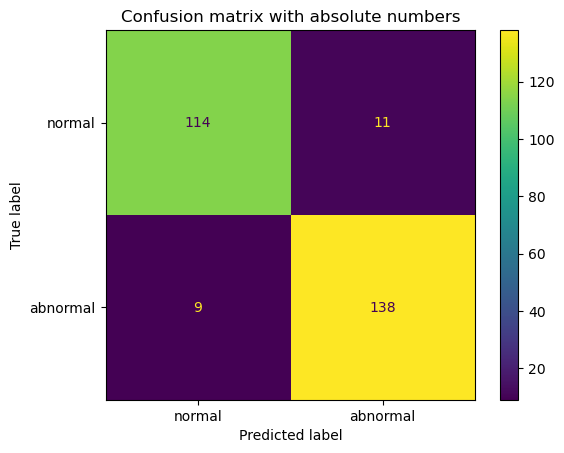

<Figure size 640x480 with 0 Axes>

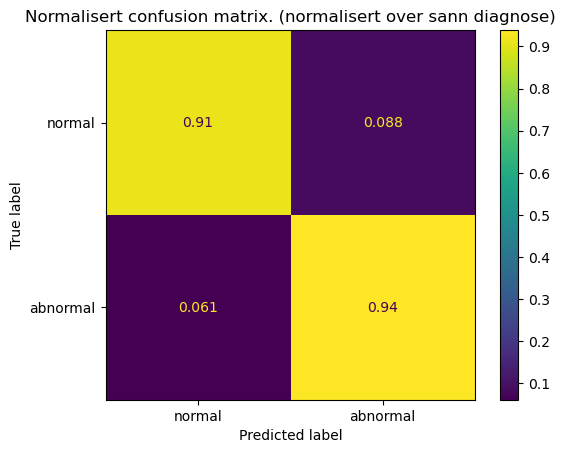

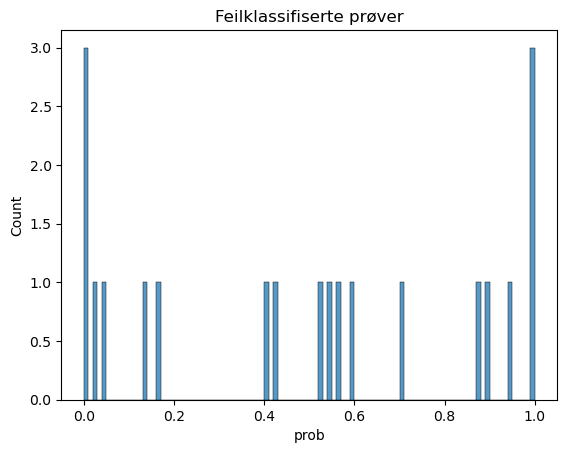

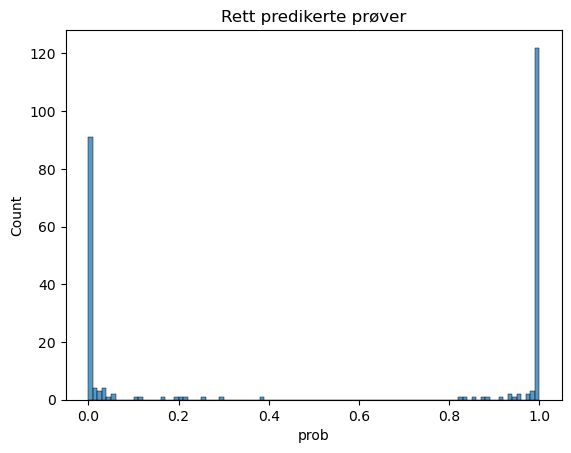

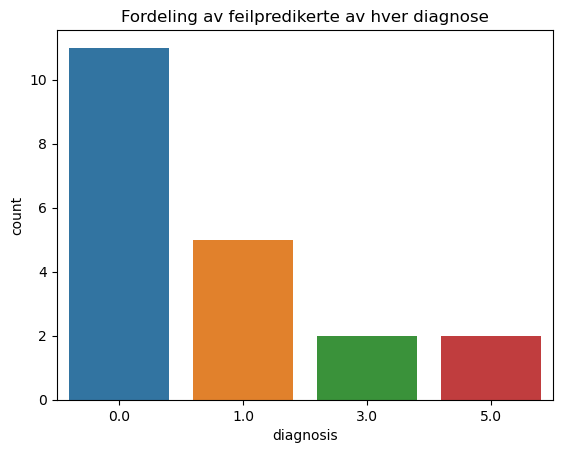

In [2]:
images, ds = image_extraction('//nmbu.no/LargeFile/Project/CubiAI/preprocess/datasets/800_normal_abnormal_2.h5')
df2 = test_result_extraction('prediction11811993.h5')
l2=check_wrong(df2,show_images=False, original_dataset=ds,images=images)
df1 = test_result_extraction('prediction11810680.h5')




Fetching all datasets of test data and making one dataframe of all of them, then closing the file.

<Figure size 640x480 with 0 Axes>

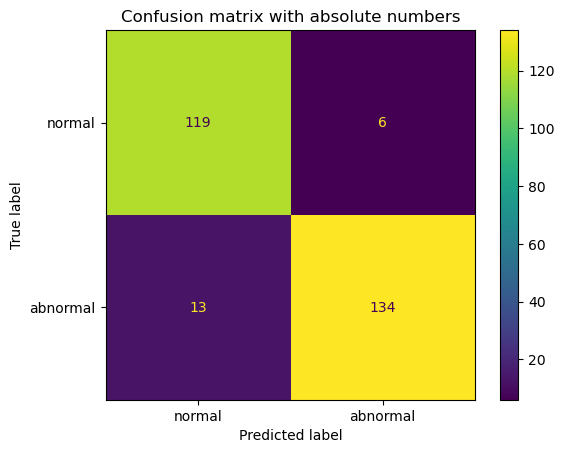

<Figure size 640x480 with 0 Axes>

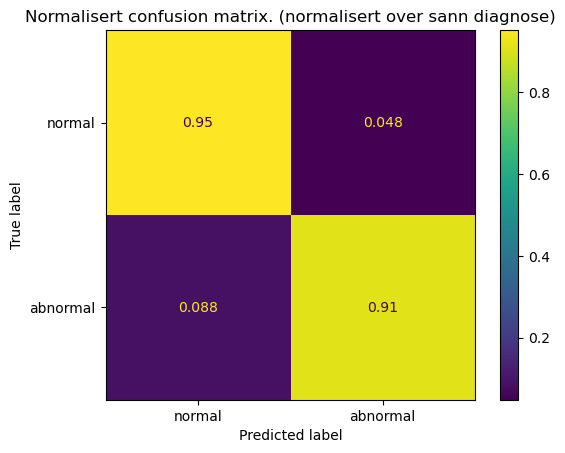

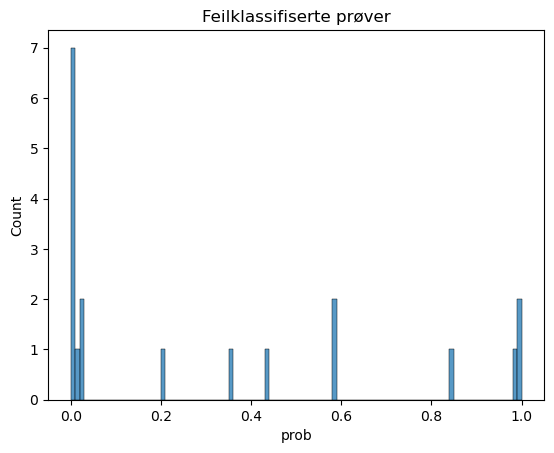

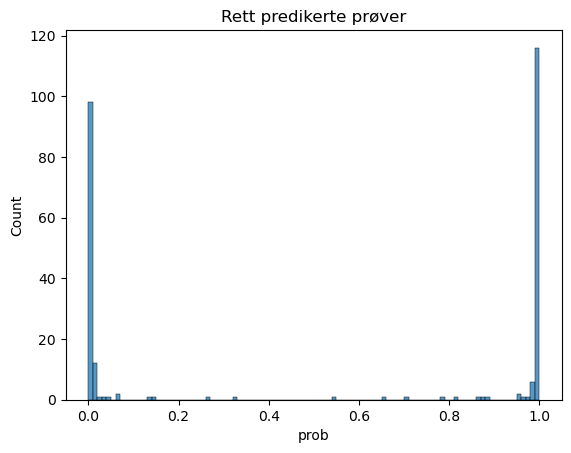

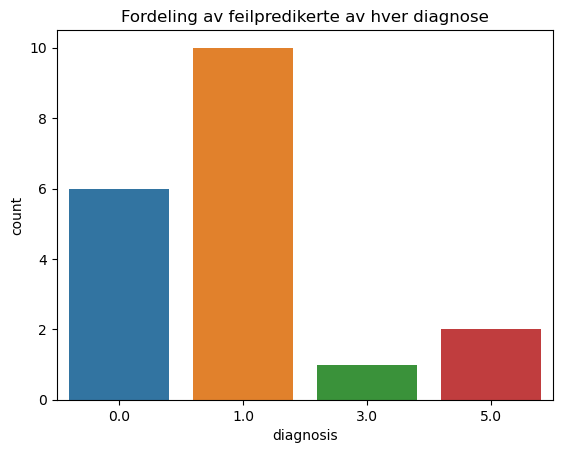

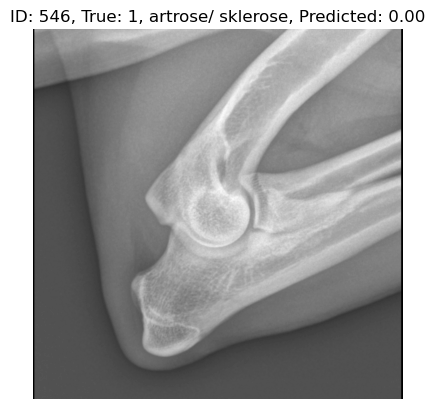

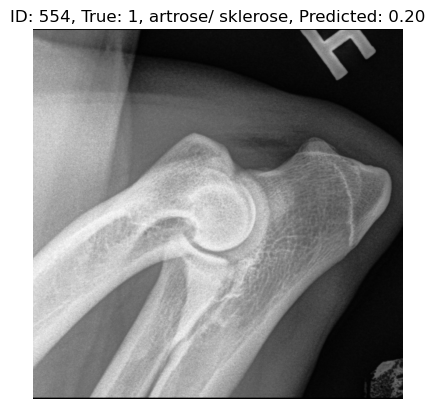

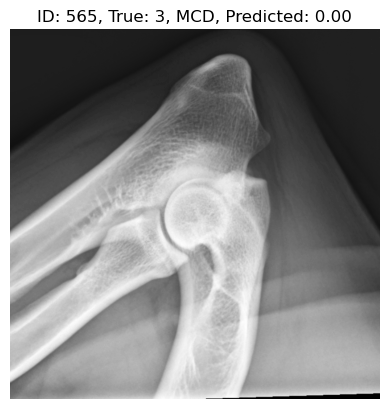

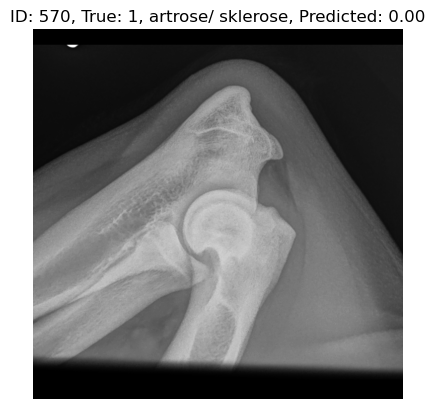

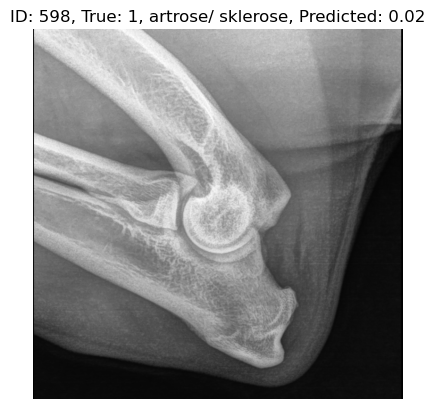

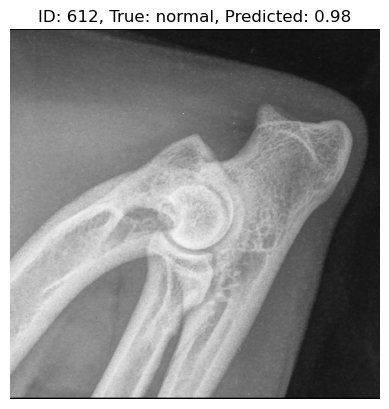

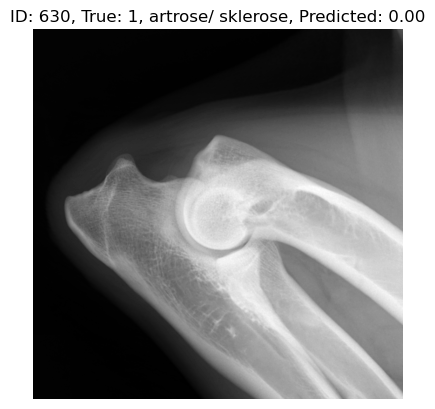

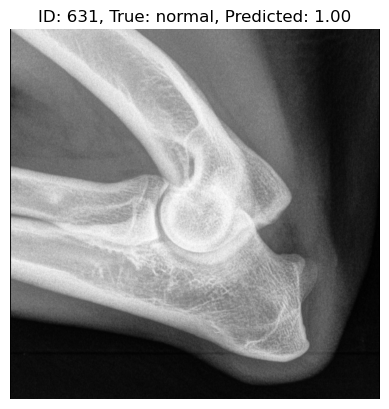

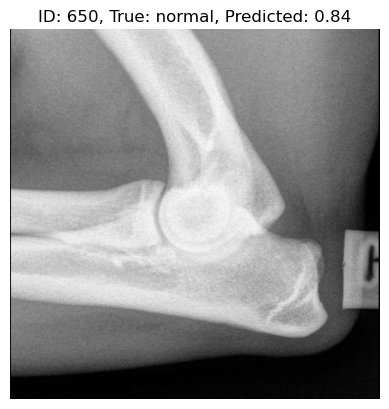

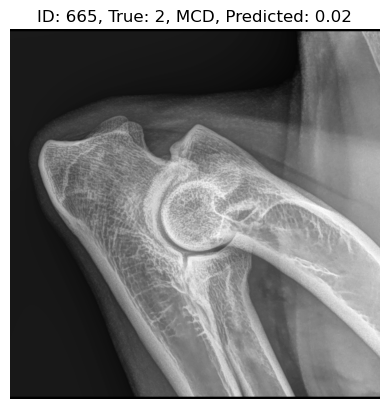

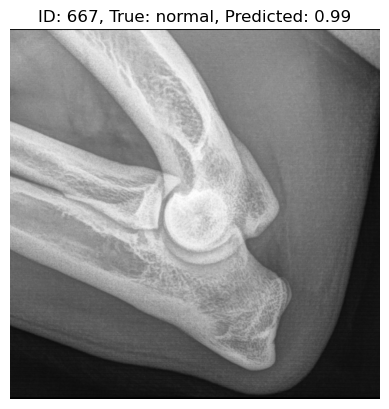

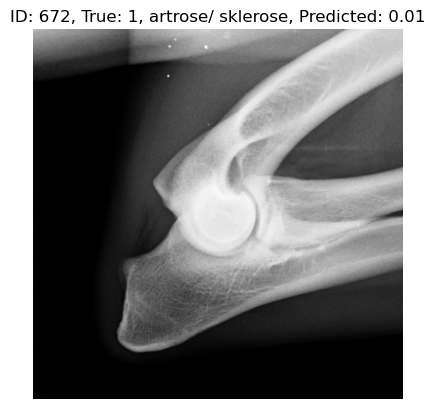

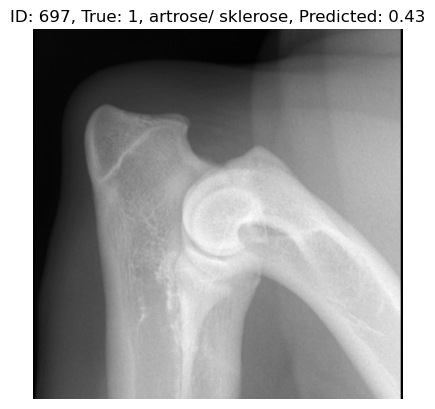

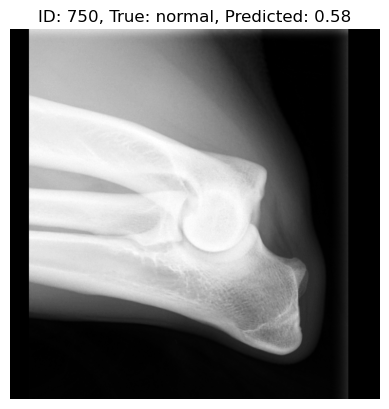

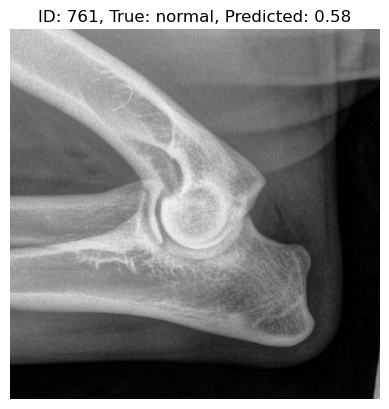

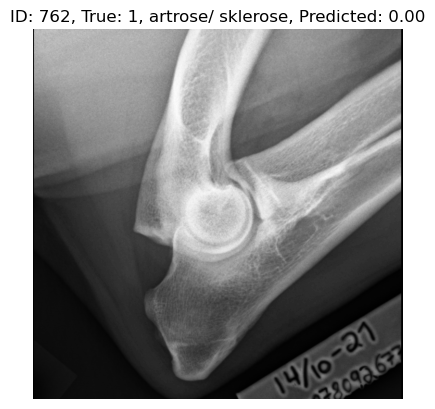

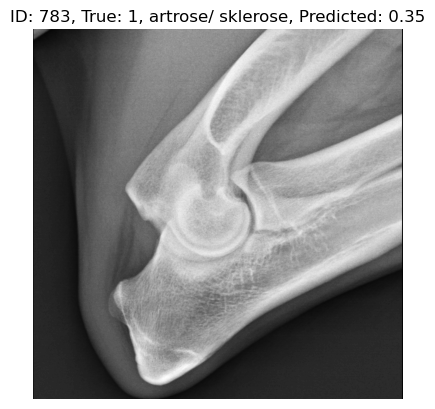

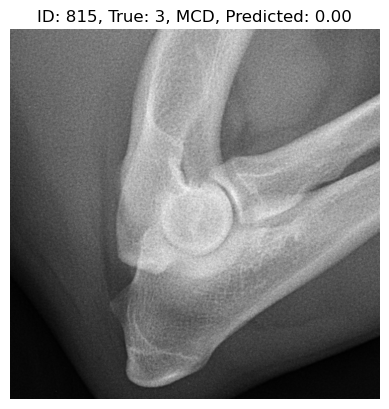

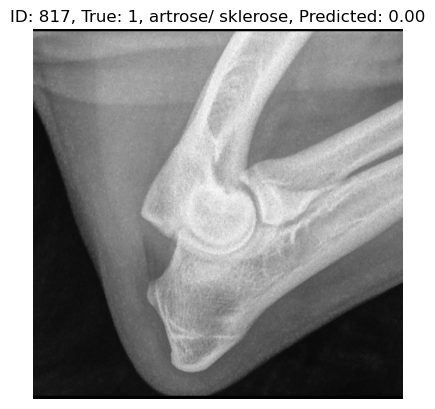

In [4]:
l1=check_wrong(df1,show_images=True, original_dataset=ds,images=images)
